In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import statsmodels.api as sm
from functools import partial as par
import functools as ft
import time
from ctypes import c_void_p, Structure, c_double, c_int, cdll, cast, POINTER
from numpy.ctypeslib import ndpointer
from sklearn.model_selection import train_test_split as tts
def F(*z):
    z = [*z]
    z[0] = [z[0]]
    return [*ft.reduce(lambda x, y: map(y, x), z)][0]
FF = lambda *z: [*ft.reduce(lambda x, y: map(y, x), z)]
fyx = lambda f, *x: lambda *y: f(*y, *x)


# Description of Problem
We want to realize an online algorithm to keep updating the results of linear regression. When we know the regression results of n1 samples and receive another n2 samples, we don't need to recalculate the linear regression of $n_1+ n_2$ samples, but merely update the old results. This is very useful when $n_1$ is large and $n_2$ is small.

# Mathematical Formula
After calculating the following linear regression for the first $n_1$ samples,
$$\hat{y} =x(x^Twx)^{-1}x^Twy,$$
where $y$ and $\hat{y}$ are $(n_1, 1)$ matrix, $x$ is $(n_1, m)$ matrix, and $w$ is diagonalized $(n_1, n_1)$ matrix, we know $x^Twx$ and $x^Twy$ are 2 $(m, m)$ matrix, which are small compared to $x$, $y$, $\hat{y}$, and $w$, since their sizes are proportional to $n_1$. Therefore, we can store their values for calculation in the next step. Now consider $(n_2, m)$ matrix $\tilde{x}$, $(n_2, 1)$ matrix $\tilde{y}$, and diagonalized $(n_2, n_2)$ matrix $\tilde{w}$ are added for linear regression.
$$\hat{y'} =\begin{pmatrix}x\\\tilde{x}\end{pmatrix}
            \left(\begin{pmatrix}x^T & \tilde{x}^T\end{pmatrix}
                    \begin{pmatrix}w & 0 \\ 0 & \tilde{w}\end{pmatrix}
                    \begin{pmatrix}x\\ \tilde{x}\end{pmatrix}\right)^{-1}
            \begin{pmatrix}x^T & \tilde{x}^T\end{pmatrix}
            \begin{pmatrix}w & 0 \\ 0 & \tilde{w}\end{pmatrix}
            \begin{pmatrix}y\\\tilde{y}\end{pmatrix}$$
$$= \begin{pmatrix}x\\\tilde{x}\end{pmatrix}(x^Twx + \tilde{x}^T\tilde{w}\tilde{x})^{-1}(x^Twy + \tilde{x}^T\tilde{w}\tilde{y}),$$
$$= \begin{pmatrix}x\\\tilde{x}\end{pmatrix}(A+B)^{-1}(C+D)$$
Since we've already known the values of A and C, their calculation complexity is $O(1)$. B is $(m, n_2) * (n_2, n_2) * (n_2, m)$. Normally, it costs $O(m n_2^2)$. But we know $\tilde{w}$ is diagonalized, and hence can optimized it to $O(mn_2)$. Similarly, D can be optimized to $O(n_2)$. Additionally A+B is $O(m^2)$, C+D is $O(m)$, (A+B)$^{-1}$ is ~$O(m^3)$ (note that the modern inversion algorithms are faster than $O(m^3)$), and (A+B)$^{-1}$(C+D) is $O(m^2)$. Therefore, the total complexity is $O(max(m^3, mn_2))$. Finally, we find a way to calculate new regression irrelevant with $n_1$.

# Programming
### The programming section has 4 parts.
1. Realize the algorithm above in `C`
2. Compile `C` program to make it linkable in `Python` 
4. Wrap `C` function in `Python`.
3. Use random data or `sp500.h5` data to test and benchmark.

## `C` Code
The `C` code is in `calculator.c`. The functions of `C` are 
```
double *inverse(double *x, int m); // A(m, m)^{-1}
double *add(double *x, double *y, int m, int n); // A(m, m) + B(m, m)
double *times(double *x, double *y, int m, int p, int n); // A(m, p) * B(p, n)
// The test for these basic functions wrapped in python can be found in benchmark.py

double *calc_xTw(double *x, double *w, int m, int n); // x^T(m, n) * w(n, n)
// We avoid using times to calculate xTw, since we know w is diagonalized.
// Additionally, we never calculate x^T, and merely use the value from the correct position.
// Both these strategies make the calculation faster and save RAM from creating a (n, n) matrix.

double *wls_iter(double *x, double *xTwx, double *xTwy,
                    double *x_next, double *w_next, double *y_next,
                    int n1, int n2, int m, bool update);
// wls_iter is the linear regression
// xTwx and xTwy are from the regression of n1
// x_next, y_next, w_next are used to calculate the regression of n1 + n2
// if update = false, only yhat of n2 samples are calculated.
// if update = true, yhat of all n1 + n2 samples are calculated.
// This is the only case that the time complexity of wls_iter depends on n1.
// Therefore, except that we really want to know the whole and new yhat, we should set it to false.

int main();
// The main program has a very large loop to test whether wls_iter free all internal memory usage correctly.
// To run it, gcc calculator.c -llapack and ./a.out
```

## Compile `C` Code to make it linkable
We need to install `lapack` first. It is easy to find in package manager of Linux/Homebrew/Windows Subsystem for Linux. Since we use `lapack`, it should be linked while compiling. Therefore, we use
```
gcc -fPIC -llapack -shared -o a.so calculator.c
```
There is a tricky thing requiring special notification. When `Python` loads `C` functions from `.so`, it loads them separately. In other words, if `C` function1 calls `C` function2, the communication between 2 functions may fail after wrapping to `cdll` in `Python`. Therefore, we need to copy all `C` functions required by `C` function1 inside `C` function1, so that `C` function1 does not require any functions outside. After avoiding this trouble, we can load `C` functions as library of `Python`.

In [2]:
lib = cdll.LoadLibrary("./a.so")

## Wrap `C` function to `Python` function
Here we only focus on the weighted linear regression. Tests on other `C` functions can be found in `benchmark.py`.

To call `C` function, we need to carefully assign the value types of all parameters, since this is the most important difference between `C` and `Python`. `y_next` is $\tilde{y}$, `x_next` is $\tilde{x}$, and `w_next` is $\tilde{w}$. The return value is `double*`, and we save it to a `numpy` array. `C` can only return one single value. Therefore, we need to separate this value to different `numpy` arrays.

In [3]:
def c_wls_iter(
    y_next, x_next, w_next, n2, m,
    x = np.array([]), xTwx = None, xTwy = None,
    n1 = 0, update = False, permutation = True
):
    tot_len = n1 + 2 * n2 + m * (m + 2)
    if xTwx is None:
        xTwx = np.zeros((m, m))
    if xTwy is None:
        xTwy = np.zeros((m, 1))
    double = lambda x: x.astype('d')
    if permutation:
        perm = F(n2, range, np.random.permutation)
        x_next = double(x_next[perm])
        w_next = double(w_next[perm])
        y_next = double(y_next[perm])
    else:
        x_next = double(x_next)
        w_next = double(w_next)
        y_next = double(y_next)
    x = double(x)
    xTwx = double(xTwx)
    xTwy = double(xTwy)
    lib.wls_iter.restype = ndpointer(dtype = c_double, shape = (tot_len,))
    results = lib.wls_iter(
        c_void_p(x.ctypes.data),
        c_void_p(xTwx.ctypes.data),
        c_void_p(xTwy.ctypes.data),
        c_void_p(x_next.ctypes.data),
        c_void_p(w_next.ctypes.data),
        c_void_p(y_next.ctypes.data),
        n1, n2, m, update
    )
    xTwx = results[:m * m].reshape(m, m)
    xTwy = results[m * m : m * (m + 1)]
    predict = results[m * (m + 1) : m * (m + 2)]
    if update:
        yhat = results[-n1 - n2:]
    else:
        yhat = None
    return xTwx, xTwy, predict, yhat

## Test whether our algorithm is correct and benchmark it
We have 2 dataset for benchmark.
1. Test on random number
2. Test on `SP500` data

From the benchmark, we want to confirm 3 things.
1. The results we get are correct compared to other methods.
2. Coding in `C` is better when comparing to use `numpy` operation directly, although the backend of `numpy` is `C` as well.
3. Our algorithm is indeed online calculation, which avoid recalculating the whole samples. 

### Test on random number

In [4]:
# Generate Random Number
m, n = 5, 50000
step = 49000
X = np.random.rand(n, m)
X1, X2 = X[:step, :], X[step:, :]
Y = np.random.rand(n)
Y1, Y2 = Y[:step], Y[step:]
w = np.random.rand(n)
w1, w2 = w[:step], w[step:]
# statsmodels
time0 = time.time()
test = sm.WLS(Y1, X1, weights = w1, missing = "drop").fit()
print(test.summary())
# my C code
time1 = time.time()
results = c_wls_iter(Y1, X1, w1, step, m, permutation = False)
xTwx, xTwy = results[0], results[1]
[print(f"x{i + 1}: {x}") for i, x in enumerate(results[2])]
# numpy matrix operation
time2 = time.time()
test1 = np.matmul(np.matmul(X1.T, np.diag(w1)), X1)
test2 = np.matmul(np.matmul(X1.T, np.diag(w1)), Y1.reshape(-1, 1))
print(np.matmul(np.linalg.inv(test1), test2))
# statsmodels
time3 = time.time()
test = sm.WLS(Y, X, weights = w, missing = "drop").fit()
print(test.summary())
# my C code
time4 = time.time()
results = c_wls_iter(Y2, X2, w2, n - step, m, n1 = step,
                        xTwx = xTwx, xTwy = xTwy, permutation = False)
[print(f"x{i + 1}: {x}") for i, x in enumerate(results[2])]
# numpy matrix operation
time5 = time.time()
test1 = xTwx + np.matmul(np.matmul(X2.T, np.diag(w2)), X2)
test2 = xTwy.reshape(-1, 1)\
        + np.matmul(np.matmul(X2.T, np.diag(w2)), Y2.reshape(-1, 1))
print(np.matmul(np.linalg.inv(test1), test2))
time6 = time.time()
print("\nTime Usage")
print(f"statsmodels WLS {step}:", time1 - time0)
print(f"C code {step}:", time2 - time1)
print(f"numpy {step}:", time3 - time2)
print("We get the same results for 3 methods above.")
print(f"statsmodels WLS {n}:", time4 - time3)
print(f"C code next {n - step}:", time5 - time4)
print(f"numpy next {n - step}:", time6 - time5)
print("We get the same results for 3 methods above.")

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.704
Model:                            WLS   Adj. R-squared (uncentered):              0.704
Method:                 Least Squares   F-statistic:                          2.327e+04
Date:                Wed, 01 Mar 2023   Prob (F-statistic):                        0.00
Time:                        00:48:37   Log-Likelihood:                         -20333.
No. Observations:               49000   AIC:                                  4.068e+04
Df Residuals:                   48995   BIC:                                  4.072e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

`numpy` is always the slowest. Although `numpy` is based on `C` as well, the problems of `numpy` are obvious. 
1. We use `double*` directly in our `C` function. However `numpy` require more complex data structure to apply all its internal operations. This can be read from that if $n$ is small, `numpy` is not extremely slower than our methods. In contrast, if $n$ is very large, `numpy` requires much larger RAM and turns extremely slower as well.
2. When using times operation of matrices to calculate $x^Twx$ and $x^Twy$, $w$ is a $(n, n)$ matrix. Compare with our algorithm, the time and space complexity here are obvious much higher.
3. The advantage of our algorithm comes from not only `C` language, but also specially designed calculation with strong flexibility.

### Use `SP500` data to test the results and benchmark the speed
we add window + 1 ($m$ = window) columns in the DataFrame fist. One is the target $y$=vlm/naive - 1, the other columns contain the information from past used for linear regression.

In [5]:
df = pd.read_hdf("sp500.h5")
temp = df["volume"].groupby(level = 1)\
                    .apply(lambda x: x.ewm(halflife = 60).mean());
df.loc[temp.index, "naive"] = temp.groupby(level = 1).shift(1);
window = 5
for i in range(window + 1):
	name = f"k{i}"
	df[name] = (df["volume"].groupby(level = 1).shift(i)
                / df["naive"] - 1)


Use trainSlice as $n_1$ part, and valSlice as $n_2$ part.

In [6]:
trainSlice = pd.IndexSlice[:"2013-01-01", :]
valSlice = pd.IndexSlice["2013-01-01":"2015-01-01":, :]
tvSlice = pd.IndexSlice[:"2015-01-01", :]
testSlice = pd.IndexSlice["2015-01-01":, :]

Create a function to convert `pandas` to `numpy` for the communication with `double*` in `C`.

In [7]:
def pd2np(df, Slice, window, permutation = False):
    YXw = [f"k{i}" for i in range(window + 1)] + ["sp_weight"]
    df_nona = df.loc[Slice, YXw].dropna()
    df_nona = df_nona.values
    tot = df_nona.shape[0]
    if permutation:
        perm = F(tot, range, np.random.permutation)
        df_nona = df_nona[perm]
    return df_nona[:, 0], df_nona[:, 1:-1], df_nona[:, -1], tot

In [8]:
Y1, X1, w1, step1 = pd2np(df, trainSlice, 5, True)
Y2, X2, w2, step2 = pd2np(df, valSlice, 5, True)
X = np.concatenate((X1, X2))
Y = np.concatenate((Y1, Y2))
w = np.concatenate((w1, w2))

### Run the benchmark in 2 cases.
1. Calculating linear regression of trainSlice
2. Calculation linear regression of trainSlice + valSlice with offline or online calculation

In [9]:
time0 = time.time()
test = sm.WLS(Y1, X1, weights = w1, missing = "drop").fit()
print(test.summary())
time1 = time.time()
results = c_wls_iter(Y1, X1, w1, step1, window, permutation = False)
xTwx = results[0]
xTwy = results[1]
[print(f"x{i + 1}: {x}") for i, x in enumerate(results[2])]
time2 = time.time()
test = sm.WLS(Y, X, weights = w, missing = "drop").fit()
print(test.summary())
time3 = time.time()
results = c_wls_iter(
    Y2, X2, w2, step2, window, n1 = step1,
    xTwx = xTwx, xTwy = xTwy, permutation = False
)
[print(f"x{i + 1}: {x}") for i, x in enumerate(results[2])]
time4 = time.time()
print("\nTime Usage")
print(f"statsmodels WLS {step1}:", time1 - time0)
print(f"C code {step1}:", time2 - time1)
print("We get the same results for 2 methods above.")
print(f"statsmodels WLS {step1 + step2}:", time3 - time2)
print(f"C code next {step2}:", time4 - time3)
print("We get the same results for 2 methods above.")

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.176
Model:                            WLS   Adj. R-squared (uncentered):              0.176
Method:                 Least Squares   F-statistic:                          5.943e+04
Date:                Wed, 01 Mar 2023   Prob (F-statistic):                        0.00
Time:                        00:48:53   Log-Likelihood:                     -1.8601e+06
No. Observations:             1388738   AIC:                                  3.720e+06
Df Residuals:                 1388733   BIC:                                  3.720e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Since `statsmodels` calculate more than just linear regression, it is hard to compare our methods directly with `statsmodels`. However, when we consider _update_ the old calculation (trainSlice) to a new result (trainSlice + valSlice), our method is clearly much more efficient.

## An example for real world usage
Keep updating the regression results everyday with reweighting newer samples to more important. To reweight the sample, we use a parameter called `halflife` describing how many days the weight of a sample will decay to half of the original values with fixed decaying ratio. Therefore, after `t` days, the weight of a sample decays to the following value.
$$w' = w * 2^{-\frac{t}{halflife}}$$
Additionally, the decaying ratio everyday is $2^{-1/halflife}$. Therefore, when we calculating $x^Twx + \tilde{x}^T\tilde{w}\tilde{x}$ for the next day, the first term will times the decaying ratio to $x^Twx * 2^{-1/halflife} +  \tilde{x}^T\tilde{w}\tilde{x}$. The same change should apply to $x^Twy$ as well.

In [10]:
def causal_regress_C(Y, X, w, halflife, warmup = 100, ts_group = "date"):
    assert warmup > 50
    ts = Y.index.get_level_values(ts_group).drop_duplicates()
    window, decay = len(X.columns), 2 ** (-1 / halflife) if halflife else 1
    _Y = Y[:ts[warmup - 1]].values
    _X = X[:ts[warmup - 1]].values
    tot = _Y.size
    if decay != 1:
        reweight = lambda t: decay ** (warmup - t - 1)
        for i in range(warmup):
            if i:
                _w = np.concatenate((_w, w.loc[ts[i]].values * reweight(i)))
            else:
                _w = w.loc[ts[i]].values * reweight(i)
    else:
        _w = w[:ts[warmup - 1]].values
    xTwx, xTwy, predict, _ = c_wls_iter(_Y, _X, _w, tot, window)
#   output = pd.DataFrame(np.nan, ts[:warmup],
#                           [f"k{i + 1}" for i in range(window)])
    output = pd.DataFrame(columns = [f"k{i + 1}" for i in range(window)])
    for date in ts[warmup:]:
        step = Y.loc[date].size
        _Y = Y.loc[date].values
        _X = X.loc[date].values
        _w = w.loc[date].values
        xTwx, xTwy, predict, _ = c_wls_iter(
            _Y, _X, _w, step, window, n1 = tot,
            xTwx = xTwx * decay,
            xTwy = xTwy * decay
        )
        output.loc[date] = {f"k{i + 1}" : x for i, x in enumerate(predict)}
        tot += step
    return output

In [11]:
def causal_regress_sm(Y, X, w, halflife, warmup = 100, ts_group = "date"):
    assert warmup > 50
    _w, ts = w.copy(), Y.index.get_level_values(ts_group).drop_duplicates()
    window, decay = len(X.columns), 2 ** (-1 / halflife) if halflife else 1
#   output = pd.DataFrame(np.nan, ts[:warmup],
#                           [f"k{i + 1}" for i in range(window)])
    output = pd.DataFrame(columns = [f"k{i + 1}" for i in range(window)])
    if decay != 1:
        for date in ts[:warmup]:
            _w[:date] *= decay
    for date in ts[warmup:]:
        output.loc[date] = sm.WLS(
            Y[:date], X[:date],
            weights = _w[:date], missing = "drop"
        ).fit().params
        _w[:date] *= decay
    return output

When `halflife` = 0, there is no weight decay. We check wether our online calculation agrees with the results from recalculating all samples everyday.

In [12]:
Slice = tvSlice
#Slice = pd.IndexSlice[:"2001-01-01", :]
YXw = [f"k{i}" for i in range(window + 1)] + ["sp_weight"]
YXwDF = df.loc[Slice, YXw].dropna()
Y = YXwDF["k0"]
X = YXwDF[[f"k{i + 1}" for i in range(window)]]
w = YXwDF["sp_weight"]
halflife = 0

In [13]:
time0 = time.time()
regression_0 = causal_regress_C(Y, X, w, halflife)
time1 = time.time()
print(time1 - time0)

9.256688356399536


In [14]:
time0 = time.time()
regression_1 = causal_regress_sm(Y, X, w, halflife)
time1 = time.time()
print(time1 - time0)

692.5491921901703


In [15]:
diff = regression_1 - regression_0
print(diff[diff > 1E-5].dropna())
print(regression_0)

Empty DataFrame
Columns: [k1, k2, k3, k4, k5]
Index: []
                  k1        k2        k3        k4        k5
2000-06-05  0.382887  0.051820  0.056615  0.018022  0.040724
2000-06-06  0.382959  0.051895  0.057334  0.018716  0.041864
2000-06-07  0.390001  0.050663  0.055845  0.016949  0.043632
2000-06-08  0.384328  0.051280  0.057933  0.016658  0.043317
2000-06-09  0.385290  0.049970  0.059001  0.018508  0.042605
...              ...       ...       ...       ...       ...
2014-12-24  0.421612  0.073212  0.048507  0.042746  0.046125
2014-12-26  0.421806  0.073203  0.048606  0.042443  0.046101
2014-12-29  0.421860  0.073281  0.048605  0.042498  0.045937
2014-12-30  0.421881  0.073332  0.048701  0.042476  0.045916
2014-12-31  0.421888  0.073335  0.048708  0.042494  0.045908

[3667 rows x 5 columns]


Next, we check when weight decay depending on `halflife`.

In [16]:
Slice = tvSlice
#Slice = pd.IndexSlice[:"2001-01-01", :]
YXw = [f"k{i}" for i in range(window + 1)] + ["sp_weight"]
YXwDF = df.loc[Slice, YXw].dropna()
Y = YXwDF["k0"]
X = YXwDF[[f"k{i + 1}" for i in range(window)]]
w = YXwDF["sp_weight"]
halflife = 252

In [17]:
time0 = time.time()
regression_2 = causal_regress_C(Y, X, w, halflife)
time1 = time.time()
print(time1 - time0)

8.471965074539185


In [18]:
time0 = time.time()
regression_3 = causal_regress_sm(Y, X, w, halflife)
time1 = time.time()
print(time1 - time0)

701.0069422721863


In [19]:
diff = regression_3 - regression_2
print(diff[diff > 1E-5].dropna())
print(regression_0)

Empty DataFrame
Columns: [k1, k2, k3, k4, k5]
Index: []
                  k1        k2        k3        k4        k5
2000-06-05  0.382887  0.051820  0.056615  0.018022  0.040724
2000-06-06  0.382959  0.051895  0.057334  0.018716  0.041864
2000-06-07  0.390001  0.050663  0.055845  0.016949  0.043632
2000-06-08  0.384328  0.051280  0.057933  0.016658  0.043317
2000-06-09  0.385290  0.049970  0.059001  0.018508  0.042605
...              ...       ...       ...       ...       ...
2014-12-24  0.421612  0.073212  0.048507  0.042746  0.046125
2014-12-26  0.421806  0.073203  0.048606  0.042443  0.046101
2014-12-29  0.421860  0.073281  0.048605  0.042498  0.045937
2014-12-30  0.421881  0.073332  0.048701  0.042476  0.045916
2014-12-31  0.421888  0.073335  0.048708  0.042494  0.045908

[3667 rows x 5 columns]


Finally, we plot how these parameters change.

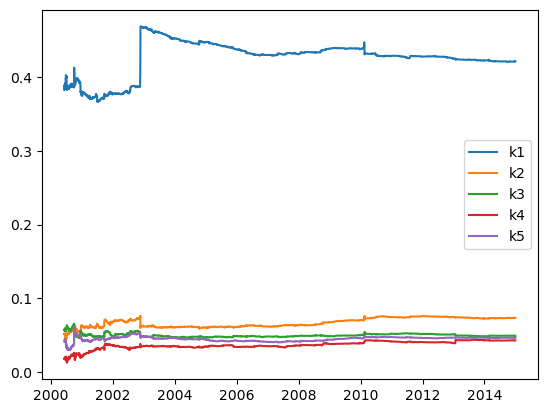

In [20]:
[plt.plot(regression_0[f"k{i + 1}"],
            label = f"k{i + 1}") for i in range(window)]
plt.legend()

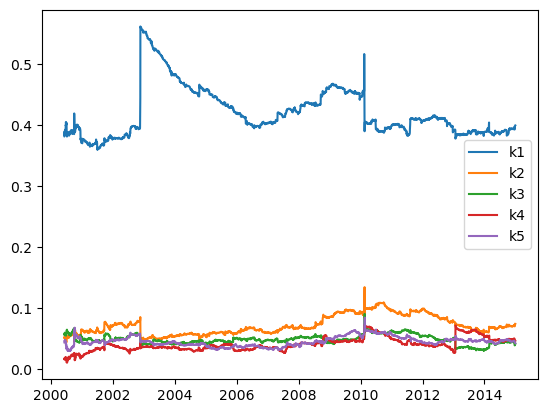

In [21]:
[plt.plot(regression_2[f"k{i + 1}"],
            label = f"k{i + 1}") for i in range(window)]
plt.legend()